In [1]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
import os
import sys
from typing import Dict, Any
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)
print(project_root)
from src.optimization.milp_schedulerv4_fixed import build_and_solve_schedule_v4
# from src.optimization.milp_schedulerv4_fixed import build_and_solve_schedule_v4

import matplotlib.pyplot as plt

/home/mak/Documents/Optimization/Project


In [2]:
# === File paths you must set ===
FIELDS = "../../data/processed/illinois_corn_fields_clean.csv"
WEATHER = "../../data/processed/noaa_il_weekly_clean.csv"
LABOR = "../../data/processed/labor_illinois_yearly_clean.csv"
MASTER = "../../data/processed/master_weekly_table.csv"

In [3]:
import pandas as pd

df = pd.read_csv("../../data/processed/labor_weekly_capacity_clean.csv")
df.head()
df.columns

Index(['year', 'week', 'labor_hours'], dtype='object')

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Your v4 model
from src.optimization.milp_schedulerv4_fixed import build_and_solve_schedule_v4

# === CONFIG ===
n_simulations = 1000
target_year = 2017

# SAME PATHS YOU USED BEFORE
field_path = "../../data/processed/illinois_corn_fields_clean.csv"
weekly_base_path = "../../data/processed/master_weekly_table_labor_2017_2024_tightened.csv"
results_out = "../../data/processed/monte_carlo_resultsv3.csv"

base_params = {
    "base_planter_capacity": 1400.0,
    "base_harvester_capacity": 950.0,
    "labor_plant_per_acre": 0.15,
    "labor_harvest_per_acre": 0.20,
    "early_penalty_weight": 10.0,
    "late_penalty_weight": 5.0,
    "statewide_corn_acres": 12_000_000,
    "time_limit": 60,
}

simulation_results = []

print("Launching Monte Carlo simulations...\n")

# === LOOP ===
for sim in tqdm(range(n_simulations)):
    
    # Load weekly base table
    wm_df = pd.read_csv(weekly_base_path)

    # Keep only the target year
    wm_yr = wm_df[wm_df["year"] == target_year].copy()

    # === Ensure column exists ===
    if "harvest_weather_factor" not in wm_yr.columns:
        wm_yr["harvest_weather_factor"] = 1.0

    # -------------------------------------------------------------------
    # 1) LABOR UNCERTAINTY (Normal shock ±20%)
    # -------------------------------------------------------------------
    labor_shock = np.random.normal(loc=1.0, scale=0.20, size=len(wm_yr))
    wm_yr["labor_hours"] = wm_yr["labor_hours"] * labor_shock
    wm_yr["labor_hours"] = wm_yr["labor_hours"].clip(lower=0)

    # -------------------------------------------------------------------
    # 2) WEATHER UNCERTAINTY — heavy rain makes capacity drop
    #    - randomly select 4 weeks to "rain"
    # -------------------------------------------------------------------
    rain_weeks = np.random.choice(wm_yr["week"], size=4, replace=False)
    
    # If precip column exists, use multiplicative noise
    if "prcp_week_in" in wm_yr.columns:
        noise = np.random.lognormal(mean=0, sigma=0.25, size=len(wm_yr))
        wm_yr["prcp_week_in_sim"] = wm_yr["prcp_week_in"] * noise
        wm_yr["capacity_factor"] = wm_yr["prcp_week_in_sim"].apply(lambda x: max(0, 1 - 0.18 * x))
    else:
        # fallback if precip is not available
        wm_yr["capacity_factor"] = 1.0

    # RAIN WEEKS: reduce harvest weather factor
    wm_yr.loc[wm_yr["week"].isin(rain_weeks), "harvest_weather_factor"] *= 0.7

    # -------------------------------------------------------------------
    # 3) Write temporary file for v4 MILP
    # -------------------------------------------------------------------
    sim_path = f"../../data/processed/mc_runsv3/master_weekly_sim_{sim}.csv"
    wm_df.loc[wm_df["year"] == target_year, "labor_hours"] = wm_yr["labor_hours"]
    wm_df.loc[wm_df["year"] == target_year, "harvest_weather_factor"] = wm_yr["harvest_weather_factor"]
    
    if "capacity_factor" in wm_yr.columns:
        wm_df.loc[wm_df["year"] == target_year, "capacity_factor"] = wm_yr["capacity_factor"]
    
    wm_df.to_csv(sim_path, index=False)

    # -------------------------------------------------------------------
    # 4) RUN v4 MILP SCHEDULER
    # -------------------------------------------------------------------
    try:
        result_df = build_and_solve_schedule_v4(
            fields_path=field_path,
            weekly_master_path=sim_path,
            target_year=target_year,
            **base_params,
        )

        # Define makespan consistently
        makespan = result_df["objective_makespan"].max()
        total_penalty = result_df["penalty"].sum()
        late_harvests = (result_df["harvest_week"] > result_df["harvest_week"].max() - 2).sum()

        simulation_results.append({
            "sim_id": sim,
            "makespan": makespan,
            "total_penalty": total_penalty,
            "late_harvests": late_harvests,
            "status": "OK",
            "error": None
        })

    except Exception as e:
        simulation_results.append({
            "sim_id": sim,
            "makespan": None,
            "total_penalty": None,
            "late_harvests": None,
            "status": "ERROR",
            "error": str(e),
        })

# === SAVE RESULTS ===
results_df = pd.DataFrame(simulation_results)
results_df.to_csv(results_out, index=False)

print(f"\nMonte Carlo Completed. Saved results to: {results_out}")
results_df.head()


📌 Total simulations: 1000
✔ Feasible: 535
❌ Infeasible: 465

================ SUMMARY STATISTICS ================



,count,mean,std,min,25%,50%,75%,max,variance
makespan,535.0,40.693458,0.540022,40.000000,40.000000,41.00,41.000000,42.000000,0.291624
total_penalty,535.0,23.771493,4.435319,11.999998,20.999994,23.25,26.999997,41.249999,19.672054
late_harvests,535.0,7.766355,2.571012,3.000000,6.000000,7.00,10.000000,15.000000,6.610102


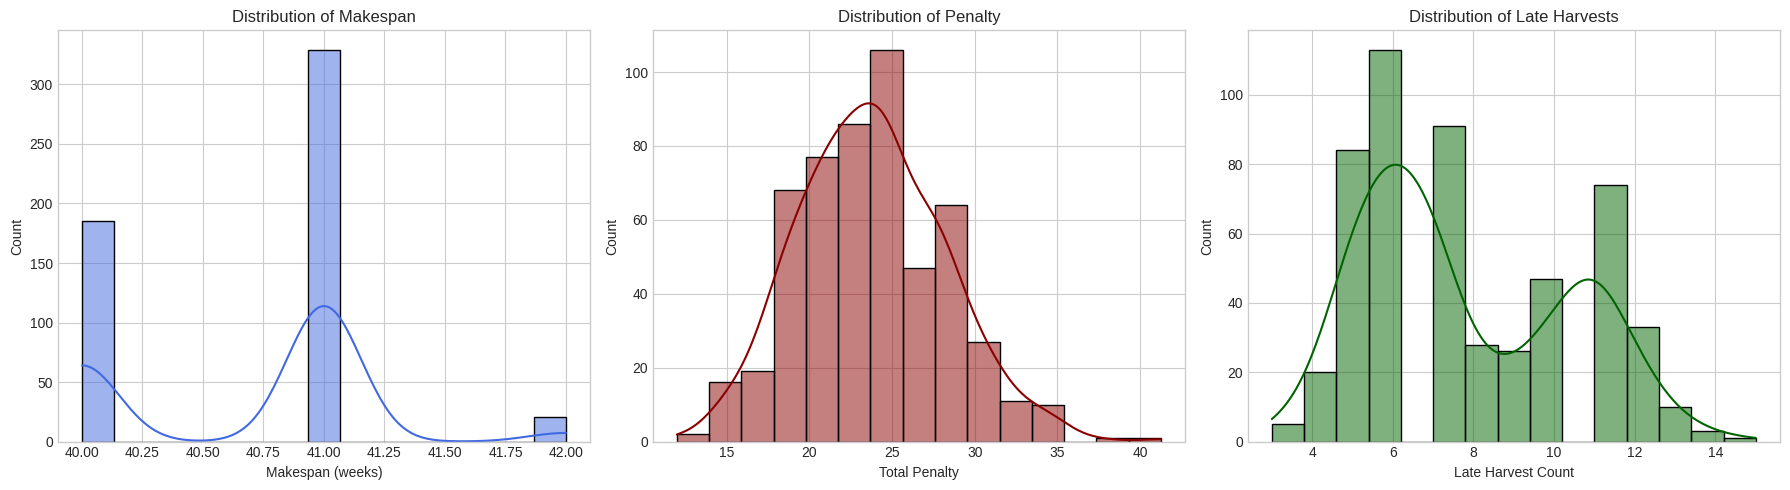

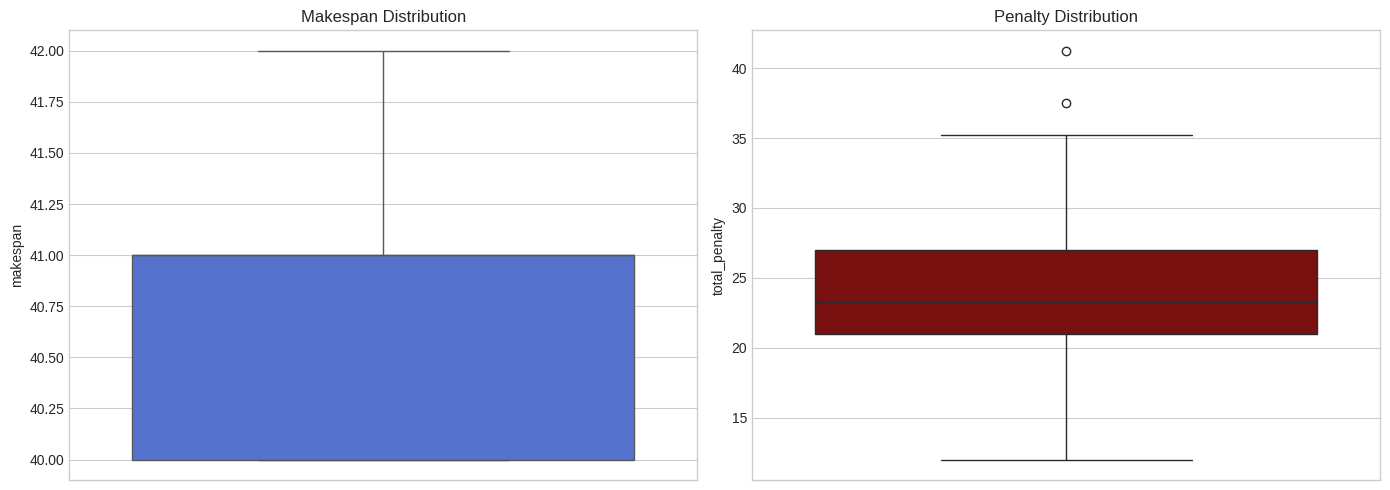

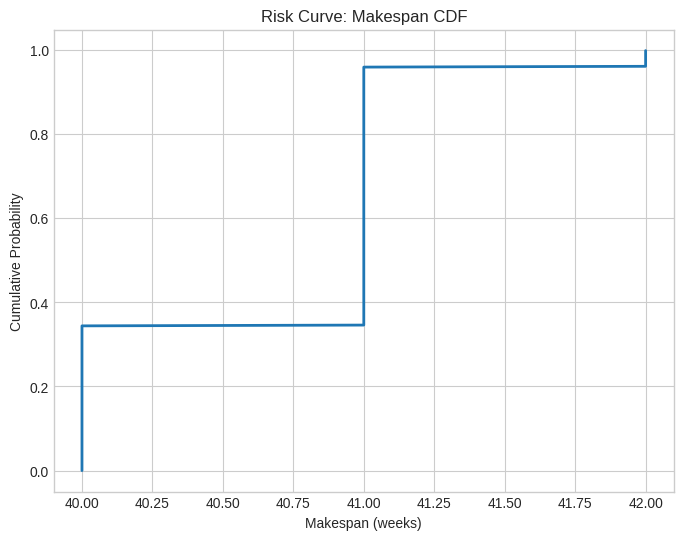


=============== RISK LEVELS (MAKESPAN) ===============
50th percentile: 41.00 weeks
75th percentile: 41.00 weeks
90th percentile: 41.00 weeks
95th percentile: 41.00 weeks
99th percentile: 42.00 weeks


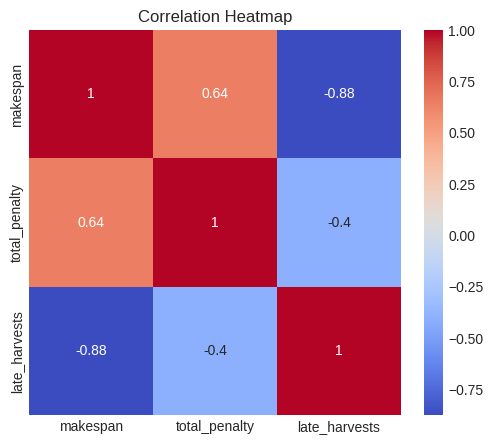

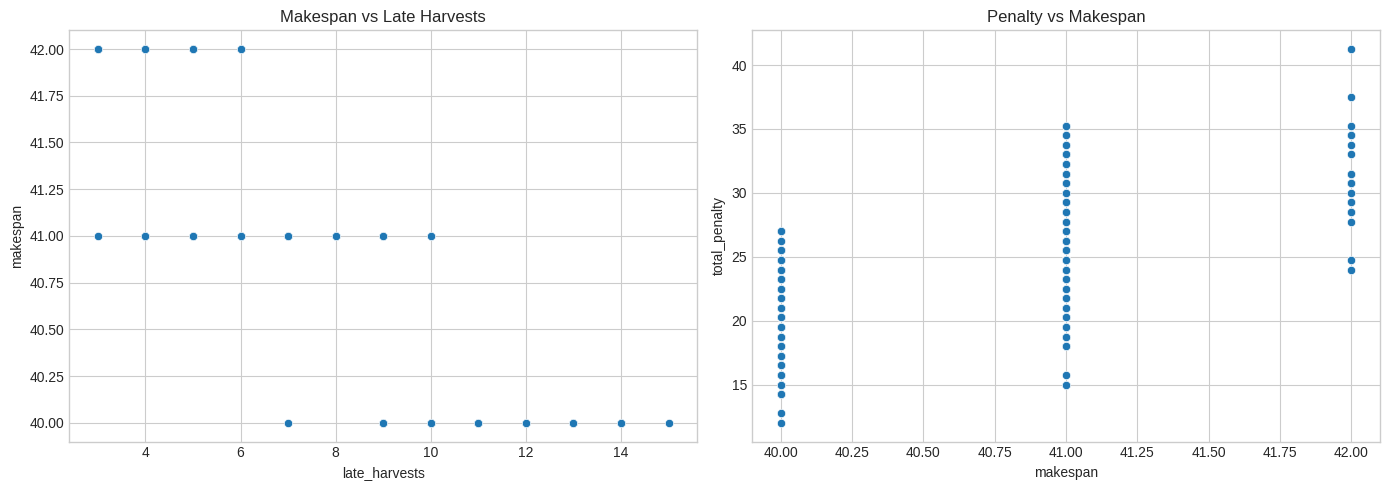


=============== BEST 5 SCENARIOS ===============


,sim_id,makespan,total_penalty,late_harvests,status,error
1,1,40.0,20.249999,10.0,OK,NaN
4,4,40.0,18.749998,11.0,OK,NaN
992,992,40.0,20.249999,11.0,OK,NaN
8,8,40.0,23.999995,10.0,OK,NaN
988,988,40.0,22.499998,11.0,OK,NaN



=============== WORST 5 SCENARIOS ===============


,sim_id,makespan,total_penalty,late_harvests,status,error
523,523,42.0,30.750000,3.0,OK,NaN
170,170,42.0,28.499997,3.0,OK,NaN
45,45,42.0,30.749999,5.0,OK,NaN
531,531,42.0,33.000000,4.0,OK,NaN
190,190,42.0,33.749999,3.0,OK,NaN



=============== STRESS-TEST SUMMARY ===============
- Average makespan: 40.69 weeks
- Worst-case makespan: 42.00 weeks
- Probability makespan exceeds 40 weeks: 65.4%
- Correlation (late harvests → makespan): -0.876
- Penalties were triggered — investigate moisture penalty curve.


In [8]:
# =========================================================
# MONTE CARLO ANALYSIS REPORT — FOR MILP v4 SIMULATION
# =========================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

RESULTS_PATH = "../../data/processed/monte_carlo_resultsv3.csv"

# Load results
df = pd.read_csv(RESULTS_PATH)

# Filter only successful runs
df_ok = df[df["status"] == "OK"].copy()

print(f"📌 Total simulations: {len(df)}")
print(f"✔ Feasible: {len(df_ok)}")
print(f"❌ Infeasible: {len(df) - len(df_ok)}")

# =========================================================
# 1) SUMMARY STATISTICS
# =========================================================

summary = df_ok[["makespan", "total_penalty", "late_harvests"]].describe().T
summary["variance"] = summary["std"] ** 2

print("\n================ SUMMARY STATISTICS ================\n")
display(summary)

# =========================================================
# 2) DISTRIBUTIONS
# =========================================================

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df_ok["makespan"], kde=True, bins=15, color="royalblue", ax=axs[0])
axs[0].set_title("Distribution of Makespan")
axs[0].set_xlabel("Makespan (weeks)")

sns.histplot(df_ok["total_penalty"], kde=True, bins=15, color="darkred", ax=axs[1])
axs[1].set_title("Distribution of Penalty")
axs[1].set_xlabel("Total Penalty")

sns.histplot(df_ok["late_harvests"], kde=True, bins=15, color="darkgreen", ax=axs[2])
axs[2].set_title("Distribution of Late Harvests")
axs[2].set_xlabel("Late Harvest Count")

plt.tight_layout()
plt.show()

# =========================================================
# 3) BOXPLOTS
# =========================================================

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(df_ok["makespan"], color="royalblue", ax=axs[0])
axs[0].set_title("Makespan Distribution")

sns.boxplot(df_ok["total_penalty"], color="darkred", ax=axs[1])
axs[1].set_title("Penalty Distribution")

plt.tight_layout()
plt.show()

# =========================================================
# 4) RISK CURVES (CDF)
# =========================================================

sorted_makespan = np.sort(df_ok["makespan"])
cdf = np.arange(len(sorted_makespan)) / float(len(sorted_makespan))

plt.figure(figsize=(8, 6))
plt.plot(sorted_makespan, cdf, linewidth=2)
plt.xlabel("Makespan (weeks)")
plt.ylabel("Cumulative Probability")
plt.title("Risk Curve: Makespan CDF")
plt.grid(True)
plt.show()

# Key percentiles
percentiles = [50, 75, 90, 95, 99]
risk_stats = {p: np.percentile(df_ok["makespan"], p) for p in percentiles}

print("\n=============== RISK LEVELS (MAKESPAN) ===============")
for p, val in risk_stats.items():
    print(f"{p}th percentile: {val:.2f} weeks")

# =========================================================
# 5) CORRELATION ANALYSIS
# =========================================================

plt.figure(figsize=(6, 5))
sns.heatmap(df_ok[["makespan", "total_penalty", "late_harvests"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Scatter plots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(data=df_ok, x="late_harvests", y="makespan", ax=axs[0])
axs[0].set_title("Makespan vs Late Harvests")

sns.scatterplot(data=df_ok, x="makespan", y="total_penalty", ax=axs[1])
axs[1].set_title("Penalty vs Makespan")

plt.tight_layout()
plt.show()

# =========================================================
# 6) BEST & WORST CASES
# =========================================================

best_5 = df_ok.sort_values("makespan").head(5)
worst_5 = df_ok.sort_values("makespan").tail(5)

print("\n=============== BEST 5 SCENARIOS ===============")
display(best_5)

print("\n=============== WORST 5 SCENARIOS ===============")
display(worst_5)

# =========================================================
# 7) STRESS TEST INTERPRETATION
# =========================================================

print("\n=============== STRESS-TEST SUMMARY ===============")
print(f"- Average makespan: {df_ok['makespan'].mean():.2f} weeks")
print(f"- Worst-case makespan: {df_ok['makespan'].max():.2f} weeks")
print(f"- Probability makespan exceeds 40 weeks: {(df_ok['makespan'] > 40).mean()*100:.1f}%")
print(f"- Correlation (late harvests → makespan): {df_ok['late_harvests'].corr(df_ok['makespan']):.3f}")

if df_ok["total_penalty"].sum() == 0:
    print("- No moisture penalty triggered in any scenario (common if your PWL curve is mild).")
else:
    print("- Penalties were triggered — investigate moisture penalty curve.")


In [9]:
def plot_late_harvest_heatmap(results_df: pd.DataFrame):
    """
    Build a heatmap showing how often each late_harvest count occurs
    across Monte Carlo runs.
    """

    # Ensure 'late_harvests' column exists
    if "late_harvests" not in results_df.columns:
        raise ValueError("results_df must contain 'late_harvests'")

    # Count frequency of each late_harvest value
    late_counts = results_df["late_harvests"].value_counts().sort_index()

    # Convert to DataFrame for plotting
    late_df = late_counts.reset_index()
    late_df.columns = ["late_harvests", "count"]

    plt.figure(figsize=(10, 4))
    sns.barplot(
        data=late_df,
        x="late_harvests",
        y="count",
        palette="coolwarm"
    )
    plt.title("Frequency of Late Harvest Counts Across Simulations")
    plt.xlabel("Number of Late Fields")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_50453/4052362881.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


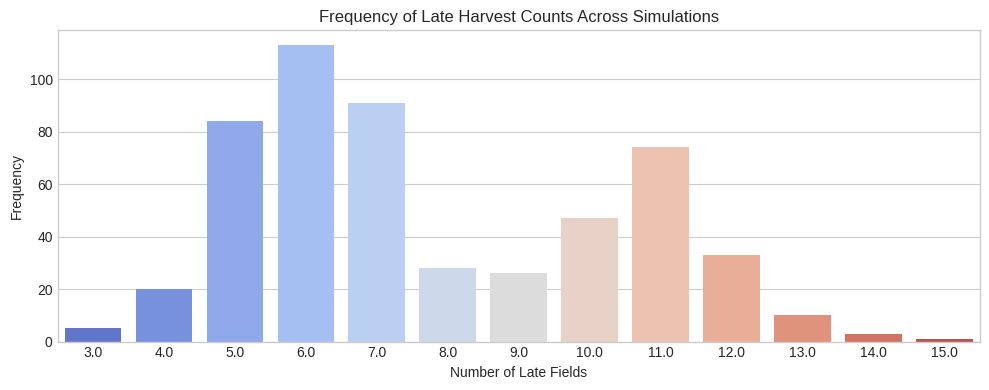

In [10]:
 plot_late_harvest_heatmap(df_ok)

Valid simulations: 100 / 100


,makespan,total_penalty,late_harvests
count,100.0,100.0,100.000000
mean,39.0,0.0,12.910000
std,0.0,0.0,0.494311
min,39.0,0.0,11.000000
50%,39.0,0.0,13.000000
90%,39.0,0.0,13.000000
95%,39.0,0.0,13.050000
max,39.0,0.0,15.000000


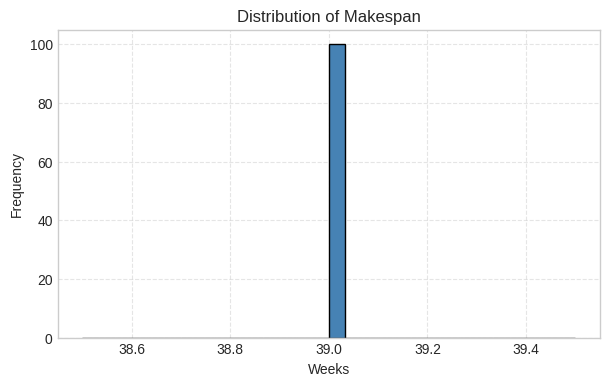

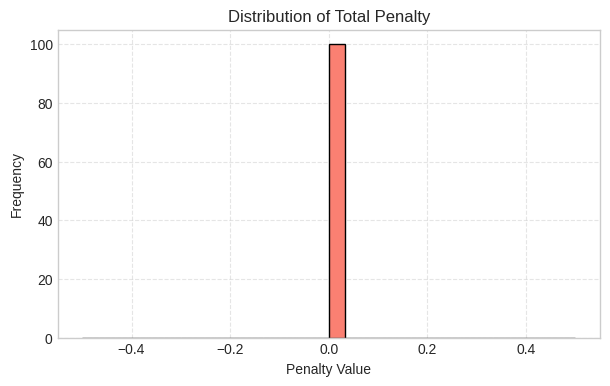

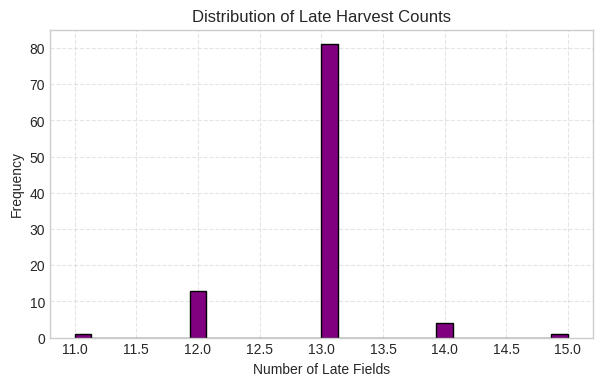

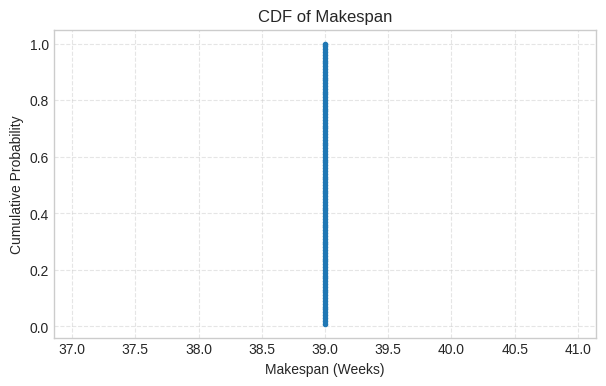

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# -----------------------------------------------------------
# 1. CLEAN THE DATA
# -----------------------------------------------------------

# Remove ERROR runs
clean_df = results_df.dropna(subset=["makespan", "total_penalty", "late_harvests"])

print(f"Valid simulations: {len(clean_df)} / {len(results_df)}")

# -----------------------------------------------------------
# 2. SUMMARY STATISTICS
# -----------------------------------------------------------

summary_stats = clean_df[["makespan", "total_penalty", "late_harvests"]].describe(
    percentiles=[0.5, 0.9, 0.95]
)

display(summary_stats)

# -----------------------------------------------------------
# 3. HISTOGRAMS
# -----------------------------------------------------------

# Makespan Histogram
plt.figure(figsize=(7,4))
plt.hist(clean_df["makespan"], bins=30, color="steelblue", edgecolor="black")
plt.title("Distribution of Makespan")
plt.xlabel("Weeks")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Penalty Histogram
plt.figure(figsize=(7,4))
plt.hist(clean_df["total_penalty"], bins=30, color="salmon", edgecolor="black")
plt.title("Distribution of Total Penalty")
plt.xlabel("Penalty Value")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Late Harvests Histogram
plt.figure(figsize=(7,4))
plt.hist(clean_df["late_harvests"], bins=30, color="purple", edgecolor="black")
plt.title("Distribution of Late Harvest Counts")
plt.xlabel("Number of Late Fields")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# -----------------------------------------------------------
# 4. MAKESPAN CDF
# -----------------------------------------------------------

sorted_makespan = clean_df["makespan"].sort_values()
cdf = sorted_makespan.rank(method="first") / len(sorted_makespan)

plt.figure(figsize=(7,4))
plt.plot(sorted_makespan.values, cdf.values, marker=".", linestyle="none")
plt.title("CDF of Makespan")
plt.xlabel("Makespan (Weeks)")
plt.ylabel("Cumulative Probability")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


Found 1000 simulation weekly files.


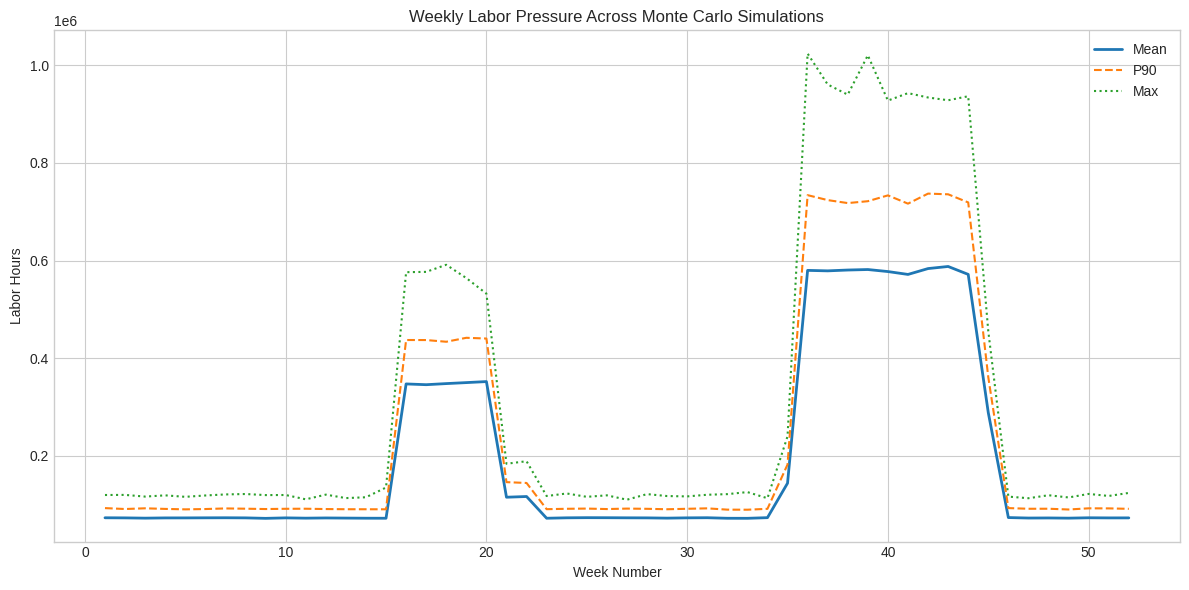

,mean_labor,p90_labor,max_labor,std_labor,median_labor
week,,,,,
1,72727.881505,92539.116393,119404.191562,14454.533262,72119.533012
2,72500.011964,90677.706011,119620.242699,14394.124486,71998.850934
3,71955.881475,92128.266576,116166.853988,14855.942626,72126.667320
4,72441.659195,90895.770893,118676.219924,14460.221250,72884.703055
5,72468.353021,89991.452259,115671.128106,13762.194122,72518.152436


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Directory + pattern for your temporary MC weekly files:
import glob
sim_files = sorted(glob.glob("../../data/processed/mc_runsv3/master_weekly_sim_*.csv"))

print(f"Found {len(sim_files)} simulation weekly files.")

# === Step 2: Initialize Aggregator ===
weekly_labor = {}

# === Step 3: Process Each Sim's Weekly Labor ===
for file in sim_files:
    df = pd.read_csv(file)
    
    # Only target-year rows
    df = df[df["year"] == 2017]

    for _, row in df.iterrows():
        week = int(row["week"])
        labor_val = row["labor_hours"]

        weekly_labor.setdefault(week, []).append(labor_val)

# === Step 4: Convert to DataFrame ===
labor_df = pd.DataFrame({
    "week": sorted(weekly_labor.keys()),
    "mean_labor": [np.mean(weekly_labor[w]) for w in sorted(weekly_labor)],
    "p90_labor": [np.percentile(weekly_labor[w], 90) for w in sorted(weekly_labor)],
    "max_labor": [np.max(weekly_labor[w]) for w in sorted(weekly_labor)],
    "std_labor": [np.std(weekly_labor[w]) for w in sorted(weekly_labor)],
    "median_labor": [np.median(weekly_labor[w]) for w in sorted(weekly_labor)],
})
labor_df.set_index("week", inplace=True)

# === Step 5: Plotting ===
plt.figure(figsize=(12, 6))
plt.plot(labor_df["mean_labor"], label="Mean", linewidth=2)
plt.plot(labor_df["p90_labor"], label="P90", linestyle="--")
plt.plot(labor_df["max_labor"], label="Max", linestyle=":")
plt.title("Weekly Labor Pressure Across Monte Carlo Simulations")
plt.xlabel("Week Number")
plt.ylabel("Labor Hours")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

labor_df.head()


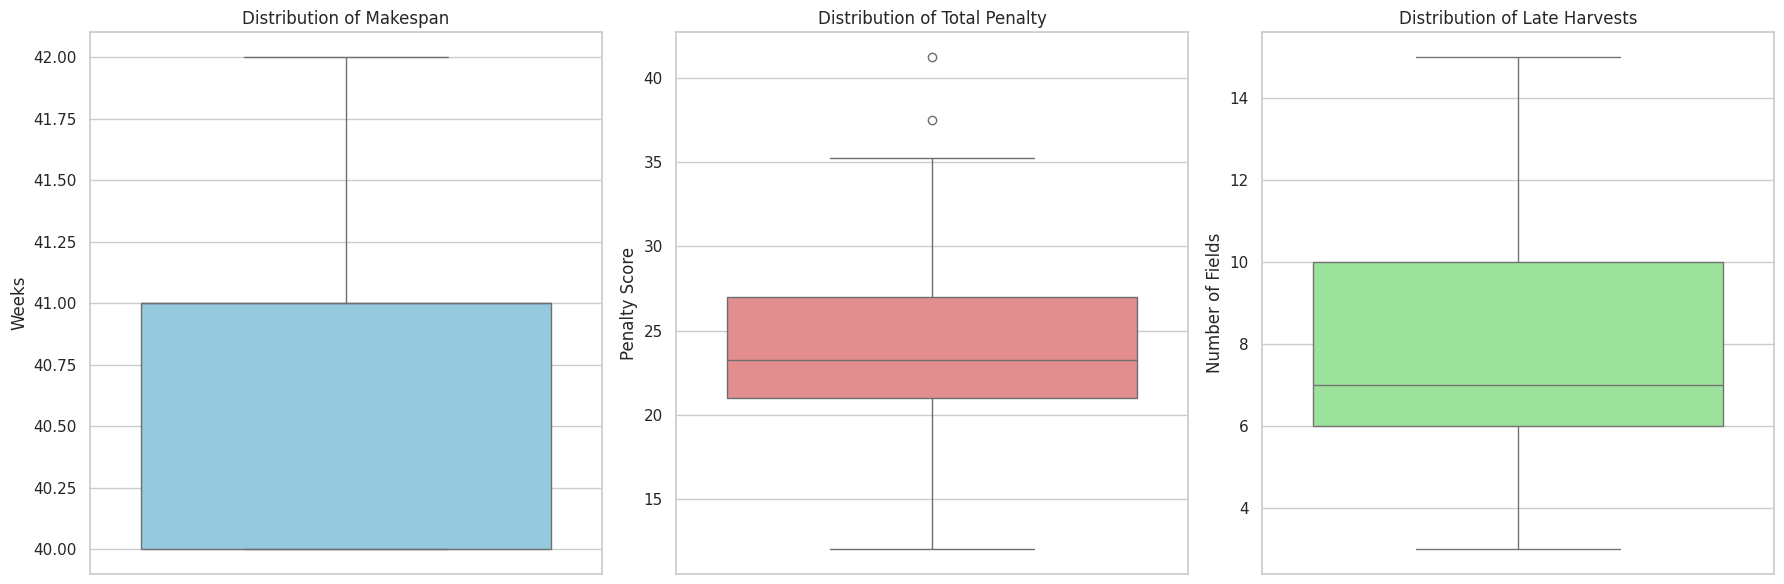

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clean successful simulation rows
clean_results = results_df.dropna(subset=["makespan", "total_penalty", "late_harvests"])

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ---------------------------------------------------------
# Plot 1: Makespan
# ---------------------------------------------------------
sns.boxplot(data=clean_results, y="makespan", ax=axes[0], color="skyblue")
axes[0].set_title("Distribution of Makespan")
axes[0].set_ylabel("Weeks")
axes[0].set_xlabel("")

# ---------------------------------------------------------
# Plot 2: Total Penalty
# ---------------------------------------------------------
sns.boxplot(data=clean_results, y="total_penalty", ax=axes[1], color="lightcoral")
axes[1].set_title("Distribution of Total Penalty")
axes[1].set_ylabel("Penalty Score")
axes[1].set_xlabel("")

# ---------------------------------------------------------
# Plot 3: Late Harvests
# ---------------------------------------------------------
sns.boxplot(data=clean_results, y="late_harvests", ax=axes[2], color="lightgreen")
axes[2].set_title("Distribution of Late Harvests")
axes[2].set_ylabel("Number of Fields")
axes[2].set_xlabel("")

plt.tight_layout()
plt.show()


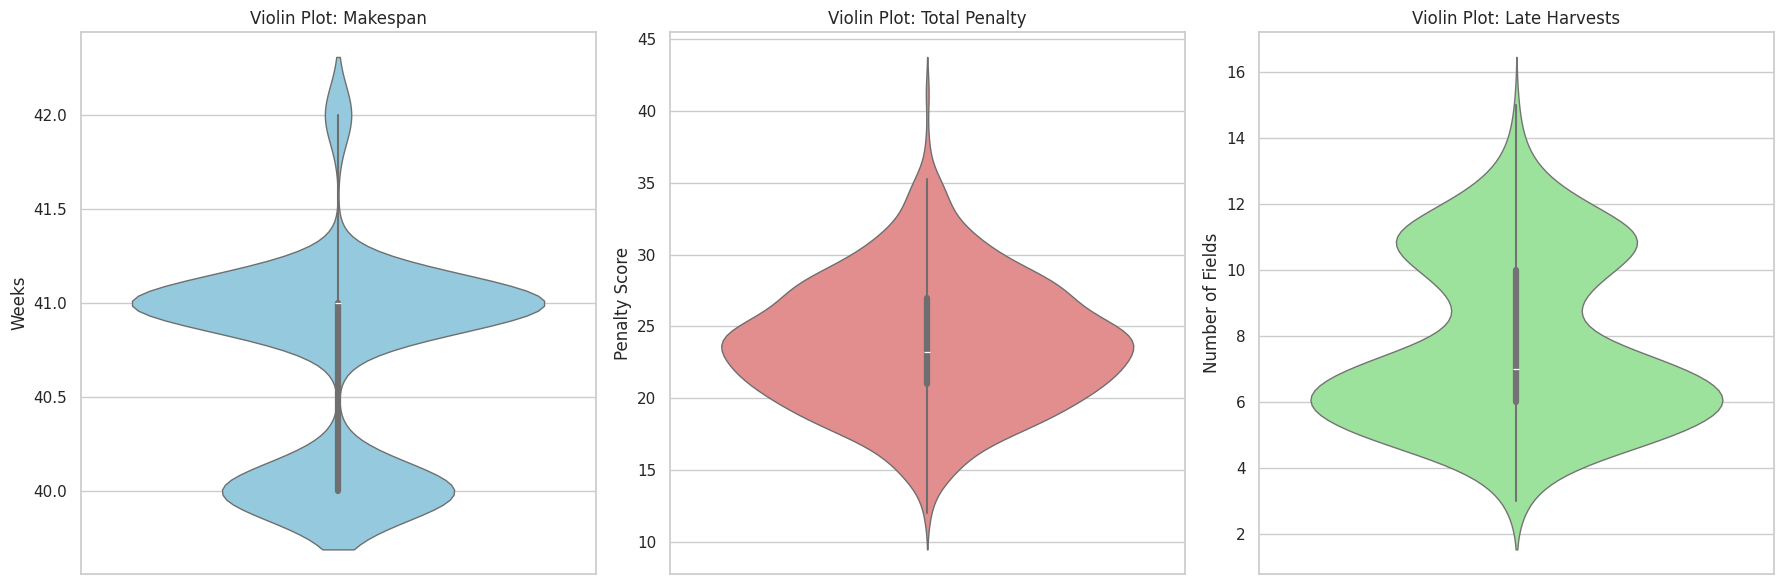

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only valid Monte Carlo runs
clean_results = results_df.dropna(subset=["makespan", "total_penalty", "late_harvests"])

sns.set(style="whitegrid")

# Set up the violin plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ---------------------------------------------------------
# Violin Plot: Makespan
# ---------------------------------------------------------
sns.violinplot(
    ax=axes[0],
    y=clean_results["makespan"],
    color="skyblue",
    linewidth=1
)
axes[0].set_title("Violin Plot: Makespan")
axes[0].set_ylabel("Weeks")

# ---------------------------------------------------------
# Violin Plot: Total Penalty
# ---------------------------------------------------------
sns.violinplot(
    ax=axes[1],
    y=clean_results["total_penalty"],
    color="lightcoral",
    linewidth=1
)
axes[1].set_title("Violin Plot: Total Penalty")
axes[1].set_ylabel("Penalty Score")

# ---------------------------------------------------------
# Violin Plot: Late Harvests
# ---------------------------------------------------------
sns.violinplot(
    ax=axes[2],
    y=clean_results["late_harvests"],
    color="lightgreen",
    linewidth=1
)
axes[2].set_title("Violin Plot: Late Harvests")
axes[2].set_ylabel("Number of Fields")

plt.tight_layout()
plt.show()
